In [ ]:
# !pip install wandb

In [ ]:
from google.colab import drive
drive.mount('/content/myDrive')

Mounted at /content/myDrive


In [ ]:
OUTPUT_DIR = './'

In [82]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import json

## Split Data

In [ ]:
!cp -r ./data/ ./

In [ ]:
import random, shutil

# Function to split data
def split_examples(source_dir, train_dir, validation_dir, train_split_rate):
  file_paths = os.listdir(source_dir)
  random.shuffle(file_paths)

  train_split_size = int(train_split_rate * len(file_paths))

  train_split = file_paths[:train_split_size]
  validation_split = file_paths[train_split_size:]

  for f in tqdm(train_split, desc='Moving training examples...') :
    shutil.copy(os.path.join(source_dir, f),
                os.path.join(train_dir, f))
  for f in tqdm(validation_split, desc='Moving validation examples...') :
    shutil.copy(os.path.join(source_dir, f),
                os.path.join(validation_dir, f))

In [ ]:
# Create train and validation dirs
!mkdir -p data/train/chest   data/validation/chest
!mkdir -p data/train/kidney  data/validation/kidney
!mkdir -p data/train/brain   data/validation/brain
# !mkdir -p data/train/heart   data/validation/heart
!mkdir -p data/train/knee  data/validation/knee

In [ ]:
# Split and move data to train & validation directories
SPLIT = 0.8 #

split_examples('data/chest', 'data/train/chest', 'data/validation/chest', SPLIT)
split_examples('data/kidney', 'data/train/kidney', 'data/validation/kidney', SPLIT)
split_examples('data/brain', 'data/train/brain', 'data/validation/brain', SPLIT)
# split_examples('data/heart', 'data/train/heart', 'data/validation/heart', SPLIT)
split_examples('data/knee', 'data/train/knee', 'data/validation/knee', SPLIT)

Moving validation examples...: 100%|██████████| 178/178 [00:00<00:00, 1806.88it/s]
Moving training examples...: 0it [00:00, ?it/s]
Moving validation examples...: 0it [00:00, ?it/s]
Moving validation examples...: 100%|██████████| 21/21 [00:00<00:00, 5306.69it/s]


# Create Generators

In [21]:
# Initiate data generators # Todo : Uncomment augmentation to use it
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    # rotation_range=40,
    # height_shift_range=.2,
    # width_shift_range=.2,
    # horizontal_flip=True,     # relevant in x-ray
    # zoom_range=.2,
    # shear_range=.2,
    # fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255.,
)

In [22]:
# Create data generators (validation split can be created automatically with "validation_split" parameter !)
train_generator = train_datagen.flow_from_directory(
    directory='data/train',
    target_size=(150, 150), # Change to 256 ?
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
)
validation_generator = validation_datagen.flow_from_directory(
    directory='data/validation',
    target_size=(150, 150), # Change to 256 ?
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 5476 images belonging to 4 classes.
Found 1371 images belonging to 4 classes.


#0. Set WandB monitor

In [23]:
import wandb

In [24]:
os.environ['WANDB_API_KEY'] = 'e911565b59c1292e9da4cc21afdc2296c174be7d'

In [25]:
#TODO Change for other model ?
wandb.init(
  project="X-ray classifier",
  id='model1',
  entity="pazuzzu",   # Enter your pseudo
  # resume='must', # TODO : Enable after implementing poursuing training from checkpoint ! Not needed for now
  config={
      "loss": "categorical_crossentropy",
      "metric": "accuracy",
  },
)
config = wandb.config

wandb: Currently logged in as: pazuzu. Use `wandb login --relogin` to force relogin


In [26]:
!mkdir runs

# Model : From Scratch (Without Transfer Learning)

## Training

In [27]:
# Hyperparameters
EPOCHS = 10
LR = 0.001
# OPTIMIZER = # TODO Externalize later

In [28]:
# Setup wandb callbacks
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="./content/runs/model_scratch_{epoch:02d}"),
]

In [29]:
class reachedAccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= .9999:
      print('\nReached 99.99% accuracy ! Cancelling training...')
      self.stop_training = True

In [31]:
# Other callbacks # TODO : Add callback when accuracy = 1 ??
reached_accuracy_callback = reachedAccuracyCallback()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
best_model_save = tf.keras.callbacks.ModelCheckpoint(f'{OUTPUT_DIR+"models/"}scratch_model_1_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# mycallbacks = [reached_accuracy_callback, early_stop, best_model_save, reduce_lr_loss]
mycallbacks = [early_stop, best_model_save, reduce_lr_loss]
callbacks = mycallbacks + wandb_callbacks

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(150, 150, 1), activation='relu',),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 82944)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [38]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate = LR,
    ),
    metrics=['accuracy'],
)

In [39]:
history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/20
172/172 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9710

wandb: Adding directory to artifact (./content/runs/model_scratch_01)... Done. 2.9s


172/172 [==============================] - 79s 439ms/step - loss: 0.1188 - accuracy: 0.9710 - val_loss: 0.0112 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 2/20
172/172 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9967

wandb: Adding directory to artifact (./content/runs/model_scratch_02)... Done. 0.3s


172/172 [==============================] - 72s 421ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0041 - val_accuracy: 0.9985 - lr: 0.0010
Epoch 3/20
172/172 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9984

wandb: Adding directory to artifact (./content/runs/model_scratch_03)... Done. 0.3s


172/172 [==============================] - 77s 447ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 1.8463e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/20
172/172 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9996

wandb: Adding directory to artifact (./content/runs/model_scratch_04)... Done. 0.3s


172/172 [==============================] - 68s 393ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 2.0143e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/20
172/172 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9954

wandb: Adding directory to artifact (./content/runs/model_scratch_05)... Done. 0.3s


172/172 [==============================] - 70s 407ms/step - loss: 0.0535 - accuracy: 0.9954 - val_loss: 1.4644e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/20
172/172 [==============================] - ETA: 0s - loss: 2.7682e-04 - accuracy: 0.9998

wandb: Adding directory to artifact (./content/runs/model_scratch_06)... Done. 0.3s


172/172 [==============================] - 68s 396ms/step - loss: 2.7682e-04 - accuracy: 0.9998 - val_loss: 0.0027 - val_accuracy: 0.9993 - lr: 0.0010
Epoch 7/20
172/172 [==============================] - ETA: 0s - loss: 8.9335e-05 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_07)... Done. 0.3s


172/172 [==============================] - 68s 396ms/step - loss: 8.9335e-05 - accuracy: 1.0000 - val_loss: 6.3743e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 8/20
172/172 [==============================] - ETA: 0s - loss: 1.9565e-05 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_08)... Done. 0.3s


172/172 [==============================] - 76s 444ms/step - loss: 1.9565e-05 - accuracy: 1.0000 - val_loss: 5.6480e-04 - val_accuracy: 0.9993 - lr: 0.0010
Epoch 9/20
172/172 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9971

wandb: Adding directory to artifact (./content/runs/model_scratch_09)... Done. 0.3s


172/172 [==============================] - 68s 397ms/step - loss: 0.0342 - accuracy: 0.9971 - val_loss: 2.9884e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 10/20
172/172 [==============================] - ETA: 0s - loss: 1.2997e-05 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_10)... Done. 0.3s


172/172 [==============================] - 75s 437ms/step - loss: 1.2997e-05 - accuracy: 1.0000 - val_loss: 1.3068e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 11/20
172/172 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9969
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


wandb: Adding directory to artifact (./content/runs/model_scratch_11)... Done. 0.8s


172/172 [==============================] - 71s 414ms/step - loss: 0.0390 - accuracy: 0.9969 - val_loss: 1.1646e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 12/20
172/172 [==============================] - ETA: 0s - loss: 1.2568e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_12)... Done. 0.3s


172/172 [==============================] - 68s 396ms/step - loss: 1.2568e-04 - accuracy: 1.0000 - val_loss: 6.3560e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 13/20
172/172 [==============================] - ETA: 0s - loss: 4.0911e-06 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_13)... Done. 0.3s


172/172 [==============================] - 70s 405ms/step - loss: 4.0911e-06 - accuracy: 1.0000 - val_loss: 4.2779e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 14/20
172/172 [==============================] - ETA: 0s - loss: 2.6444e-06 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_14)... Done. 0.3s


172/172 [==============================] - 68s 399ms/step - loss: 2.6444e-06 - accuracy: 1.0000 - val_loss: 3.7997e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 15/20
172/172 [==============================] - ETA: 0s - loss: 1.9233e-06 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_15)... Done. 0.3s


172/172 [==============================] - 68s 395ms/step - loss: 1.9233e-06 - accuracy: 1.0000 - val_loss: 3.5997e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/20
172/172 [==============================] - ETA: 0s - loss: 1.4512e-06 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_16)... Done. 0.3s


172/172 [==============================] - 70s 407ms/step - loss: 1.4512e-06 - accuracy: 1.0000 - val_loss: 3.0954e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/20
172/172 [==============================] - ETA: 0s - loss: 1.1370e-06 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_17)... Done. 0.3s


172/172 [==============================] - 76s 445ms/step - loss: 1.1370e-06 - accuracy: 1.0000 - val_loss: 2.6694e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/20
172/172 [==============================] - ETA: 0s - loss: 9.0631e-07 - accuracy: 1.0000
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


wandb: Adding directory to artifact (./content/runs/model_scratch_18)... Done. 0.3s


172/172 [==============================] - 70s 409ms/step - loss: 9.0631e-07 - accuracy: 1.0000 - val_loss: 2.3390e-08 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/20
172/172 [==============================] - ETA: 0s - loss: 7.2130e-07 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_19)... Done. 0.3s


172/172 [==============================] - 69s 401ms/step - loss: 7.2130e-07 - accuracy: 1.0000 - val_loss: 2.3216e-08 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 20/20
172/172 [==============================] - ETA: 0s - loss: 7.0727e-07 - accuracy: 1.0000

wandb: Adding directory to artifact (./content/runs/model_scratch_20)... Done. 0.3s


172/172 [==============================] - 68s 395ms/step - loss: 7.0727e-07 - accuracy: 1.0000 - val_loss: 2.2955e-08 - val_accuracy: 1.0000 - lr: 1.0000e-05


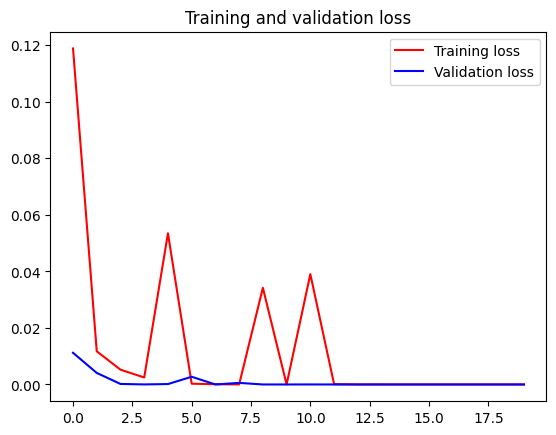

<Figure size 640x480 with 0 Axes>

In [41]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

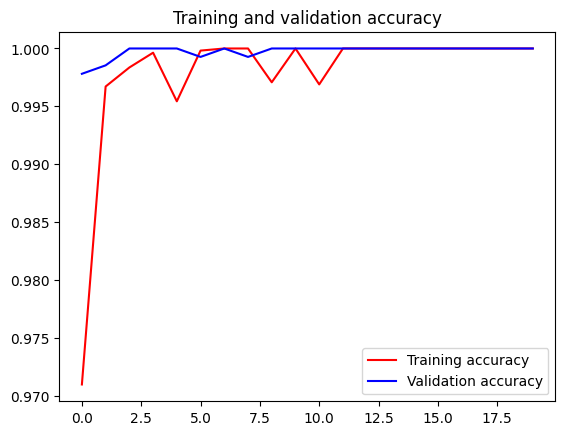

<Figure size 640x480 with 0 Axes>

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

## Evaluation

In [45]:
model.evaluate(validation_generator)

43/43 [==============================] - 14s 319ms/step - loss: 2.2955e-08 - accuracy: 1.0000


[2.2954882439307767e-08, 1.0]

In [57]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [96]:
# Save model
# model.save(OUTPUT_DIR + 'models/' + '4_class_20_ep.h5') # Full model

In [108]:
labels_dict = {v: k for k, v in train_generator.class_indices.items()}

In [98]:
# # Save class indices
# with open(OUTPUT_DIR + 'models/' + 'labels_dict.json', 'w') as f :
#   json.dump(labels_dict, f)

In [ ]:
# Confusion matrix and see if wee need down sampling or new data for heart

## Inference

In [99]:
# Load model
loaded_model = tf.keras.models.load_model(OUTPUT_DIR + 'models/' + '4_class_20_ep.h5')

In [117]:
# Load labels dict
with open(OUTPUT_DIR + 'models/' + 'labels_dict.json') as f :
  labels_dict = json.load(f)

In [118]:
def predict_from_image_array(img_array: np.array) -> str:
  img_array = np.array([img_array]) / 255.
  out = loaded_model.predict(img_array, verbose=0)
  out = np.argmax(out)
  prediction = labels_dict[str(out)]
  return prediction

In [ ]:
img_path = 

In [121]:
img = tf.keras.utils.load_img(
    # '/content/data/chest/IM-0006-0001.jpeg', # chest example
  # '/content/data/knee/9004184_1.png', # knee example
  '/content/data/kidney/Cyst- (1008).jpg', # kidney example
  # ', # brain example
    color_mode="grayscale",
    target_size=(150, 150),)

img_array = tf.keras.utils.img_to_array(img)

In [122]:
predict_from_image_array(img_array)

'kidney'